In [1]:
import torch.nn as nn
import torch
from PIL import Image
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import normalize
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

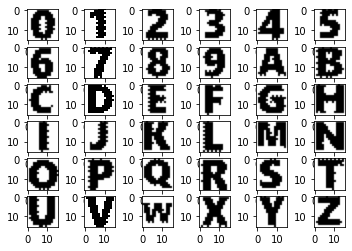

In [2]:
# Step 1
# Get the image and change every image to an 256-dimention vector
dataSet = np.zeros([36, 256])
f=lambda x: x + 55 if x > 9 else x + 48
for i in range(0, 36):
    # TODO Change PNG to jpg
    inputImageDir = './dataSet1/' + chr(f(i)) + str(1) + '.PNG'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
    plt.subplot(6,6,i+1)
    plt.imshow(inputImage)
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet[i] = array
dataSet = np.array(dataSet)

In [3]:
# Step 2
# define a neural network
class Perceptron(nn.Module):

    def __init__(self, input_size, d_hidden, num_classes):
        super(Perceptron, self).__init__()
        self.linear0 = nn.Linear(input_size, d_hidden[0])
        self.activate0 = nn.ReLU()
        self.linear1 = nn.Linear(d_hidden[0], d_hidden[1])
        self.activate1 = nn.ReLU()
        self.linear2 = nn.Linear(d_hidden[1], d_hidden[2])
        self.activate2 = nn.ReLU()
        self.linear3 = nn.Linear(d_hidden[2], d_hidden[3])
        self.activate3 = nn.ReLU()
        self.linear4 = nn.Linear(d_hidden[3],num_classes)
        self.activate4 = nn.Sigmoid()

        
    def forward(self, x):
        res = self.linear0(x)
        res = self.activate0(res)
        res = self.linear1(res)
        res = self.activate1(res)
        res = self.linear2(res)
        res = self.activate2(res)
        res = self.linear3(res)
        res = self.activate3(res)
        res = self.linear4(res)
        res = self.activate4(res)
        return res

In [4]:
class DigitDataset(Dataset):
    def __init__(self, dataset, label_list):
        self.dataset = dataset
        self.label_list = label_list
    def __len__(self):
        return len(self.label_list)
    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.label_list[idx]
        return {
            'data': torch.from_numpy(data).float(),
            'label': torch.from_numpy(label).float()
        }

In [5]:
# Parameters of training
learning_rate = 0.001
# Train until the error become the lowest
# get the optimization of MAE or MSE
num_epochs = 600
batch_size, input_size, num_classes = 36, 256, 256
d_hidden=[320, 320, 320, 320]

# Load the dataset
train_dataset = DigitDataset(dataset = dataSet, label_list = dataSet)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cpu')
model = Perceptron(input_size=input_size, d_hidden=d_hidden,num_classes=num_classes).to(device)

# Setup for noise training
if not os.path.exists('./models1'):
    os.mkdir('./models1')
torch.save(model, './models1/net_untrained.pkl')
for i in range(5):
    if not os.path.exists('./models1/' + str(i) + '/'):
        os.mkdir('./models1/' + str(i) + '/')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [6]:
# Step 3
model = Perceptron(input_size=input_size, d_hidden=d_hidden, num_classes=num_classes).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
def train(dataloader, model, num_epochs):
    # research regarding epoch to explain why we need that many iterations (num_epochs)
    for epoch in range(num_epochs):
        losses = []
        ERROR_Train = []
        model.train() 
        for i, data in enumerate(dataloader, 0):
            model.zero_grad()
            # data['data'] is each image data in dataset
            real_cpu, label_cpu = data['data'], data['label']
#             if torch.cuda.is_available():
#                 real_cpu = real_cpu.cuda() 
#                 label_cpu = label_cpu.cuda()
            real = real_cpu
            label = label_cpu
            inputv = Variable(real)
            labelv = Variable(label)
            output = model(inputv)
            err = criterion(output, labelv) 
            err.backward() 
            optimizer.step() 

            losses.append(err.data.item())
            error = label - output.data
#             print(error.shape)
            ERROR_Train.extend(error)
#         print(ERROR_Train)
        MAE = torch.mean(torch.abs(torch.stack(ERROR_Train)))
        ME = torch.mean(torch.stack(ERROR_Train))
        STD = torch.std(torch.stack(ERROR_Train)) 
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print('[%d/%d] Loss: %.4f MAE: %.4f Mean Error: %.4f STD: %.4f' % (epoch, num_epochs, np.average(losses), MAE, ME, STD))
    return output, model

# Start training        
output, model = train(train_loader, model, num_epochs)
# print(output.type)

[0/600] Loss: 0.2502 MAE: 0.5002 Mean Error: 0.0752 STD: 0.4946
[10/600] Loss: 0.1786 MAE: 0.2975 Mean Error: 0.0213 STD: 0.4221
[20/600] Loss: 0.1590 MAE: 0.3207 Mean Error: -0.0125 STD: 0.3986
[30/600] Loss: 0.1328 MAE: 0.2743 Mean Error: 0.0022 STD: 0.3645
[40/600] Loss: 0.1158 MAE: 0.2297 Mean Error: -0.0006 STD: 0.3403
[50/600] Loss: 0.1065 MAE: 0.2088 Mean Error: 0.0134 STD: 0.3261
[60/600] Loss: 0.0968 MAE: 0.1916 Mean Error: 0.0085 STD: 0.3111
[70/600] Loss: 0.0862 MAE: 0.1760 Mean Error: 0.0059 STD: 0.2935
[80/600] Loss: 0.0704 MAE: 0.1489 Mean Error: -0.0005 STD: 0.2654
[90/600] Loss: 0.0537 MAE: 0.1120 Mean Error: 0.0060 STD: 0.2317
[100/600] Loss: 0.0413 MAE: 0.0847 Mean Error: 0.0045 STD: 0.2031
[110/600] Loss: 0.0325 MAE: 0.0649 Mean Error: 0.0014 STD: 0.1804
[120/600] Loss: 0.0263 MAE: 0.0509 Mean Error: 0.0027 STD: 0.1621
[130/600] Loss: 0.0221 MAE: 0.0407 Mean Error: 0.0013 STD: 0.1488
[140/600] Loss: 0.0195 MAE: 0.0336 Mean Error: 0.0010 STD: 0.1397
[150/600] Loss: 0.

(36, 256)


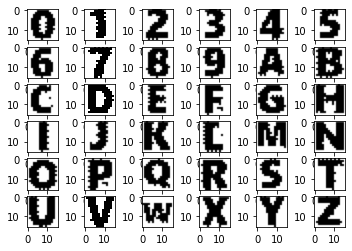

In [7]:
# Step 4
# Step 4a
# TODO create new for dataset 1
if not os.path.exists('./ass1output'):
    os.mkdir('./ass1output')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models1/net_trained.pkl')
output_dataset1 = np.zeros([36, 256])
for i in range(36):
    output_img = output_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_img))
    img = img.convert("1")
    plt.subplot(6,6,i+1)
    plt.imshow(img)
    output_path = './ass1output/' + str(i) + '.png'
    img.save(output_path)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset1[i] = array


(36, 256)


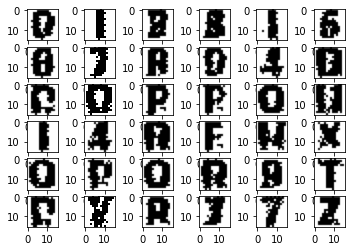

In [8]:
# Step 4
# Step 4b
# Export the image after training
# Before executing this block, create a folder called "output"

# read dataset2 images
dataSet2 = np.zeros([36, 256])
f=lambda x: x + 55 if x > 9 else x + 48
for i in range(0, 36):
    # TODO Change PNG to jpg
    inputImageDir = './dataSet2/' + chr(f(i)) + str(2) + '.jpg'
    outputImageDir = './dataSet2/' + chr(f(i)) + str(2) + '.png'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
#     plt.subplot(6,6,i+1)
#     plt.imshow(inputImage)
    inputImage.save(outputImageDir)
    outputImage = Image.open(outputImageDir)
    data = outputImage.getdata()
    array = np.array(data)/255
    dataSet2[i] = array
dataSet2 = np.array(dataSet2)

if not os.path.exists('./ass2output'):
    os.mkdir('./ass2output')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models1/net_trained.pkl')
output_dataset2 = np.zeros([36, 256])
output_dataset2_model = model(torch.from_numpy(dataSet2).float())
output_np = output_dataset2_model.detach().numpy()
for i in range(36):
    output_img = output_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_img))
    img = img.convert("1")
    plt.subplot(6,6,i+1)
    plt.imshow(img)
    output_path2 = './ass2output/' + str(i) + '.png'
    img.save(output_path2)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset2[i] = array

In [9]:
# Calculate Fh
def calculateFh(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Fh_denominator = 0    # Fh分母
    Fh_numerator = 0      # Fh分子
    Fh_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 0:
                Fh_denominator = Fh_denominator + 1
                if output_dataset[j][i] == 0:
                    Fh_numerator = Fh_numerator + 1
        Fh = Fh_numerator / Fh_denominator
        Fh_array[j] = Fh
    return Fh_array

In [10]:
# Calculate Ffa
def calculateFfa(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Ffa_denominator = 0    # Ffa分母
    Ffa_numerator = 0      # Ffa分子
    Ffa_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 1:
                Ffa_denominator = Ffa_denominator + 1
            if output_dataset[j][i] == 0 and input_dataset[j][i] == 1:
                Ffa_numerator = Ffa_numerator + 1
        Ffa = Ffa_numerator / Ffa_denominator
        Ffa_array[j] = Ffa
    return Ffa_array

In [11]:
Fh_array1 = calculateFh(dataSet, output_dataset1)
Ffa_array1 = calculateFfa(dataSet, output_dataset1)
Fh_array2 = calculateFh(dataSet2, output_dataset2)
Ffa_array2 = calculateFfa(dataSet2, output_dataset2)
print(Fh_array2)
print(Ffa_array2)

[0.92771084 0.95620438 0.94202899 0.92857143 0.91202346 0.90909091
 0.90797546 0.90925926 0.91401274 0.91537377 0.89401496 0.89558665
 0.89494549 0.88849558 0.87714988 0.87175573 0.87366927 0.87144703
 0.87282878 0.87241583 0.87162534 0.86694826 0.85636723 0.8460452
 0.84697987 0.84421682 0.84612261 0.84719536 0.8471028  0.84328628
 0.84304775 0.8426084  0.83809524 0.83679336 0.83525741 0.83632492]
[0.21387283 0.12266667 0.16221034 0.19354839 0.17039404 0.1789194
 0.18879509 0.18899204 0.18914081 0.18854673 0.18718967 0.19412039
 0.20008624 0.20374898 0.20733104 0.20495334 0.20829086 0.20784314
 0.19833948 0.19900788 0.20387532 0.20064205 0.20481616 0.20447761
 0.20552221 0.20403431 0.2034165  0.20619681 0.20720152 0.20398617
 0.20676101 0.20710621 0.2087729  0.20796698 0.20712424 0.20627425]


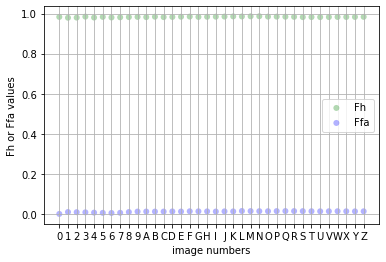

In [12]:
# TODO: Step 4c: Answer 2 questions from canvas
# Q1 Yes there is mismatch
# Q2 Should we compare Dataset2 output vs Dataset1 input? 50-50
# Why or why not?  (Justify your answer with analysis in the report generated in Step 8, below, and think about test, training, and validation datasets).
# TODO visualize Y' (dataset2 output) with X (dataset1 input) to Justify answer (think about test, training)

# Step 4d Graph Fh as a function of Ffa for each exemplar in the input dataset
# Graph for X comparing with Y
import numpy as np
import matplotlib.pyplot as plt

# noiseless
fig, ax = plt.subplots()

Image_name = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# ax.scatter([1,2,3,4,5,6,7,8,9,10], Fh_array, c="green", label="Fh", alpha=0.3, edgecolors='none')
# ax.scatter([1,2,3,4,5,6,7,8,9,10], Ffa_array, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.scatter(Image_name, Fh_array1, c="green", label="Fh", alpha=0.3, edgecolors='none')
ax.scatter(Image_name, Ffa_array1, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.legend()
ax.grid(True)
plt.xlabel("image numbers")
plt.ylabel("Fh or Ffa values")
# plt.yscale("log")
plt.show()


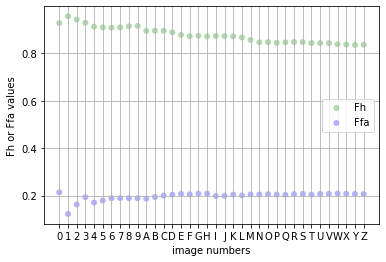

In [13]:
# Graph for X' compare with Y'
# noiseless
fig, ax = plt.subplots()

Image_name = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# ax.scatter([1,2,3,4,5,6,7,8,9,10], Fh_array, c="green", label="Fh", alpha=0.3, edgecolors='none')
# ax.scatter([1,2,3,4,5,6,7,8,9,10], Ffa_array, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.scatter(Image_name, Fh_array2, c="green", label="Fh", alpha=0.3, edgecolors='none')
ax.scatter(Image_name, Ffa_array2, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.legend()
ax.grid(True)
plt.xlabel("image numbers")
plt.ylabel("Fh or Ffa values")
# plt.yscale("log")
plt.show()

In [14]:
# Display the Ffa and Fh in a table form X compare with Y

import sys
from prettytable import PrettyTable
table1 = PrettyTable()
table1.field_names = ['Character','Fh','Ffa']

for i in range(36):
    table1.add_row([Image_name[i],Fh_array1[i],round(Ffa_array1[i],5)])
print(table1)

+-----------+--------------------+---------+
| Character |         Fh         |   Ffa   |
+-----------+--------------------+---------+
|     0     | 0.9833333333333333 |   0.0   |
|     1     | 0.9792746113989638 |  0.0094 |
|     2     |        0.98        | 0.00855 |
|     3     | 0.9847328244274809 | 0.00792 |
|     4     | 0.9801980198019802 | 0.00645 |
|     5     | 0.9834983498349835 | 0.00538 |
|     6     | 0.980528511821975  | 0.00466 |
|     7     | 0.9813895781637717 | 0.00564 |
|     8     | 0.9825517993456925 | 0.00937 |
|     9     | 0.9833659491193738 |  0.0117 |
|     A     | 0.9823008849557522 | 0.01186 |
|     B     | 0.9843505477308294 | 0.01171 |
|     C     | 0.9823917828319882 |  0.0117 |
|     D     | 0.9831989247311828 |  0.0124 |
|     E     | 0.9841872232764073 | 0.01195 |
|     F     | 0.984984984984985  | 0.01316 |
|     G     | 0.9832589285714286 | 0.01289 |
|     H     | 0.9839378238341969 |  0.0127 |
|     I     | 0.9844455594581034 | 0.01184 |
|     J   

In [15]:
# Display the Ffa and Fh in a table form X' compare with Y'

table2 = PrettyTable()
table2.field_names = ['Character','Fh','Ffa']

for i in range(36):
    table2.add_row([Image_name[i],Fh_array2[i],round(Ffa_array2[i],5)])
print(table2)

+-----------+--------------------+---------+
| Character |         Fh         |   Ffa   |
+-----------+--------------------+---------+
|     0     | 0.927710843373494  | 0.21387 |
|     1     | 0.9562043795620438 | 0.12267 |
|     2     | 0.9420289855072463 | 0.16221 |
|     3     | 0.9285714285714286 | 0.19355 |
|     4     | 0.9120234604105572 | 0.17039 |
|     5     | 0.9090909090909091 | 0.17892 |
|     6     | 0.9079754601226994 |  0.1888 |
|     7     | 0.9092592592592592 | 0.18899 |
|     8     | 0.9140127388535032 | 0.18914 |
|     9     | 0.9153737658674189 | 0.18855 |
|     A     | 0.8940149625935162 | 0.18719 |
|     B     | 0.8955866523143164 | 0.19412 |
|     C     | 0.8949454905847374 | 0.20009 |
|     D     | 0.8884955752212389 | 0.20375 |
|     E     | 0.8771498771498771 | 0.20733 |
|     F     | 0.8717557251908397 | 0.20495 |
|     G     | 0.8736692689850958 | 0.20829 |
|     H     | 0.8714470284237726 | 0.20784 |
|     I     | 0.8728287841191067 | 0.19834 |
|     J   

Training dataset with noise standard deviation 0.001
[0/600] Loss: 0.2501 MAE: 0.5000 Mean Error: 0.0752 STD: 0.4944
[10/600] Loss: 0.1761 MAE: 0.3001 Mean Error: 0.0179 STD: 0.4193
[20/600] Loss: 0.1649 MAE: 0.3301 Mean Error: -0.0102 STD: 0.4060
[30/600] Loss: 0.1566 MAE: 0.3321 Mean Error: 0.0047 STD: 0.3957
[40/600] Loss: 0.1354 MAE: 0.2717 Mean Error: -0.0076 STD: 0.3679
[50/600] Loss: 0.1243 MAE: 0.2552 Mean Error: -0.0072 STD: 0.3526
[60/600] Loss: 0.1148 MAE: 0.2335 Mean Error: -0.0033 STD: 0.3389
[70/600] Loss: 0.1014 MAE: 0.2095 Mean Error: -0.0032 STD: 0.3185
[80/600] Loss: 0.0886 MAE: 0.1763 Mean Error: 0.0029 STD: 0.2977
[90/600] Loss: 0.0798 MAE: 0.1574 Mean Error: 0.0061 STD: 0.2825
[100/600] Loss: 0.0692 MAE: 0.1392 Mean Error: -0.0003 STD: 0.2631
[110/600] Loss: 0.0589 MAE: 0.1193 Mean Error: -0.0014 STD: 0.2428
[120/600] Loss: 0.0551 MAE: 0.1071 Mean Error: 0.0097 STD: 0.2345
[130/600] Loss: 0.0451 MAE: 0.0899 Mean Error: -0.0032 STD: 0.2124
[140/600] Loss: 0.0408 MAE

[590/600] Loss: 0.0143 MAE: 0.0156 Mean Error: -0.0024 STD: 0.1197
[599/600] Loss: 0.0143 MAE: 0.0155 Mean Error: -0.0024 STD: 0.1197
------------------------------------
Training dataset with noise standard deviation 0.003
[0/600] Loss: 0.2507 MAE: 0.5006 Mean Error: 0.0763 STD: 0.4949
[10/600] Loss: 0.1795 MAE: 0.2951 Mean Error: 0.0228 STD: 0.4231
[20/600] Loss: 0.1640 MAE: 0.3299 Mean Error: -0.0101 STD: 0.4049
[30/600] Loss: 0.1485 MAE: 0.3195 Mean Error: 0.0014 STD: 0.3854
[40/600] Loss: 0.1308 MAE: 0.2578 Mean Error: -0.0032 STD: 0.3616
[50/600] Loss: 0.1213 MAE: 0.2446 Mean Error: -0.0041 STD: 0.3483
[60/600] Loss: 0.1111 MAE: 0.2263 Mean Error: -0.0093 STD: 0.3331
[70/600] Loss: 0.0963 MAE: 0.1977 Mean Error: -0.0046 STD: 0.3103
[80/600] Loss: 0.0847 MAE: 0.1671 Mean Error: -0.0110 STD: 0.2909
[90/600] Loss: 0.0728 MAE: 0.1460 Mean Error: 0.0001 STD: 0.2698
[100/600] Loss: 0.0615 MAE: 0.1264 Mean Error: 0.0016 STD: 0.2480
[110/600] Loss: 0.0519 MAE: 0.1079 Mean Error: -0.0041 

[580/600] Loss: 0.0193 MAE: 0.0205 Mean Error: -0.0015 STD: 0.1390
[590/600] Loss: 0.0193 MAE: 0.0205 Mean Error: -0.0015 STD: 0.1390
[599/600] Loss: 0.0193 MAE: 0.0204 Mean Error: -0.0015 STD: 0.1390
------------------------------------
Training dataset with noise standard deviation 0.01
[0/600] Loss: 0.2505 MAE: 0.5004 Mean Error: 0.0750 STD: 0.4949
[10/600] Loss: 0.1767 MAE: 0.3015 Mean Error: 0.0197 STD: 0.4199
[20/600] Loss: 0.1648 MAE: 0.3256 Mean Error: -0.0121 STD: 0.4059
[30/600] Loss: 0.1513 MAE: 0.3236 Mean Error: 0.0030 STD: 0.3890
[40/600] Loss: 0.1317 MAE: 0.2613 Mean Error: -0.0026 STD: 0.3629
[50/600] Loss: 0.1209 MAE: 0.2430 Mean Error: -0.0019 STD: 0.3477
[60/600] Loss: 0.1123 MAE: 0.2300 Mean Error: 0.0024 STD: 0.3351
[70/600] Loss: 0.1023 MAE: 0.2097 Mean Error: -0.0026 STD: 0.3198
[80/600] Loss: 0.0914 MAE: 0.1820 Mean Error: -0.0120 STD: 0.3020
[90/600] Loss: 0.0789 MAE: 0.1578 Mean Error: -0.0069 STD: 0.2809
[100/600] Loss: 0.0685 MAE: 0.1381 Mean Error: -0.0066 

[570/600] Loss: 0.0169 MAE: 0.0184 Mean Error: -0.0024 STD: 0.1302
[580/600] Loss: 0.0169 MAE: 0.0184 Mean Error: -0.0024 STD: 0.1302
[590/600] Loss: 0.0169 MAE: 0.0184 Mean Error: -0.0022 STD: 0.1300
[599/600] Loss: 0.0168 MAE: 0.0183 Mean Error: -0.0023 STD: 0.1298
------------------------------------
Training dataset with noise standard deviation 0.03
[0/600] Loss: 0.2506 MAE: 0.5005 Mean Error: 0.0748 STD: 0.4950
[10/600] Loss: 0.1757 MAE: 0.3021 Mean Error: 0.0167 STD: 0.4189
[20/600] Loss: 0.1643 MAE: 0.3221 Mean Error: -0.0087 STD: 0.4053
[30/600] Loss: 0.1497 MAE: 0.3172 Mean Error: 0.0013 STD: 0.3870
[40/600] Loss: 0.1297 MAE: 0.2530 Mean Error: -0.0025 STD: 0.3602
[50/600] Loss: 0.1169 MAE: 0.2389 Mean Error: -0.0032 STD: 0.3419
[60/600] Loss: 0.1033 MAE: 0.2095 Mean Error: -0.0018 STD: 0.3214
[70/600] Loss: 0.0900 MAE: 0.1825 Mean Error: 0.0005 STD: 0.3000
[80/600] Loss: 0.0785 MAE: 0.1568 Mean Error: 0.0005 STD: 0.2802
[90/600] Loss: 0.0692 MAE: 0.1386 Mean Error: 0.0041 ST

[560/600] Loss: 0.0193 MAE: 0.0209 Mean Error: -0.0033 STD: 0.1390
[570/600] Loss: 0.0193 MAE: 0.0208 Mean Error: -0.0033 STD: 0.1390
[580/600] Loss: 0.0193 MAE: 0.0208 Mean Error: -0.0033 STD: 0.1390
[590/600] Loss: 0.0193 MAE: 0.0208 Mean Error: -0.0033 STD: 0.1390
[599/600] Loss: 0.0193 MAE: 0.0207 Mean Error: -0.0033 STD: 0.1390
------------------------------------
Training dataset with noise standard deviation 0.1
[0/600] Loss: 0.2499 MAE: 0.4998 Mean Error: 0.0749 STD: 0.4943
[10/600] Loss: 0.1735 MAE: 0.3052 Mean Error: 0.0163 STD: 0.4162
[20/600] Loss: 0.1640 MAE: 0.3224 Mean Error: -0.0113 STD: 0.4048
[30/600] Loss: 0.1468 MAE: 0.3127 Mean Error: 0.0026 STD: 0.3831
[40/600] Loss: 0.1296 MAE: 0.2567 Mean Error: -0.0057 STD: 0.3600
[50/600] Loss: 0.1182 MAE: 0.2392 Mean Error: 0.0004 STD: 0.3438
[60/600] Loss: 0.1071 MAE: 0.2162 Mean Error: 0.0038 STD: 0.3272
[70/600] Loss: 0.0961 MAE: 0.1948 Mean Error: 0.0054 STD: 0.3100
[80/600] Loss: 0.0833 MAE: 0.1700 Mean Error: 0.0019 STD

[550/600] Loss: 0.0155 MAE: 0.0172 Mean Error: -0.0021 STD: 0.1247
[560/600] Loss: 0.0155 MAE: 0.0171 Mean Error: -0.0021 STD: 0.1247
[570/600] Loss: 0.0155 MAE: 0.0170 Mean Error: -0.0021 STD: 0.1246
[580/600] Loss: 0.0155 MAE: 0.0169 Mean Error: -0.0021 STD: 0.1246
[590/600] Loss: 0.0155 MAE: 0.0169 Mean Error: -0.0021 STD: 0.1246
[599/600] Loss: 0.0155 MAE: 0.0169 Mean Error: -0.0021 STD: 0.1246
------------------------------------
Training dataset with noise standard deviation 0.002
[0/600] Loss: 0.2496 MAE: 0.4995 Mean Error: 0.0755 STD: 0.4939
[10/600] Loss: 0.1737 MAE: 0.3054 Mean Error: 0.0037 STD: 0.4168
[20/600] Loss: 0.1634 MAE: 0.3192 Mean Error: -0.0024 STD: 0.4043
[30/600] Loss: 0.1438 MAE: 0.2985 Mean Error: -0.0020 STD: 0.3792
[40/600] Loss: 0.1275 MAE: 0.2523 Mean Error: -0.0039 STD: 0.3570
[50/600] Loss: 0.1163 MAE: 0.2368 Mean Error: -0.0048 STD: 0.3410
[60/600] Loss: 0.1042 MAE: 0.2157 Mean Error: -0.0091 STD: 0.3227
[70/600] Loss: 0.0911 MAE: 0.1836 Mean Error: 0.0

[540/600] Loss: 0.0197 MAE: 0.0212 Mean Error: 0.0005 STD: 0.1402
[550/600] Loss: 0.0197 MAE: 0.0212 Mean Error: 0.0005 STD: 0.1402
[560/600] Loss: 0.0196 MAE: 0.0212 Mean Error: 0.0006 STD: 0.1401
[570/600] Loss: 0.0197 MAE: 0.0216 Mean Error: 0.0004 STD: 0.1404
[580/600] Loss: 0.0204 MAE: 0.0229 Mean Error: -0.0012 STD: 0.1427
[590/600] Loss: 0.0507 MAE: 0.0625 Mean Error: 0.0107 STD: 0.2250
[599/600] Loss: 0.0564 MAE: 0.0669 Mean Error: 0.0068 STD: 0.2375
------------------------------------
Training dataset with noise standard deviation 0.005
[0/600] Loss: 0.2502 MAE: 0.5001 Mean Error: 0.0750 STD: 0.4946
[10/600] Loss: 0.1763 MAE: 0.3004 Mean Error: 0.0204 STD: 0.4194
[20/600] Loss: 0.1586 MAE: 0.3163 Mean Error: -0.0067 STD: 0.3982
[30/600] Loss: 0.1377 MAE: 0.2754 Mean Error: -0.0051 STD: 0.3711
[40/600] Loss: 0.1249 MAE: 0.2558 Mean Error: -0.0076 STD: 0.3534
[50/600] Loss: 0.1143 MAE: 0.2301 Mean Error: -0.0087 STD: 0.3380
[60/600] Loss: 0.1035 MAE: 0.2096 Mean Error: -0.0061 

[540/600] Loss: 0.0184 MAE: 0.0197 Mean Error: -0.0018 STD: 0.1355
[550/600] Loss: 0.0184 MAE: 0.0196 Mean Error: -0.0018 STD: 0.1355
[560/600] Loss: 0.0184 MAE: 0.0196 Mean Error: -0.0018 STD: 0.1355
[570/600] Loss: 0.0184 MAE: 0.0196 Mean Error: -0.0018 STD: 0.1355
[580/600] Loss: 0.0184 MAE: 0.0196 Mean Error: -0.0018 STD: 0.1355
[590/600] Loss: 0.0184 MAE: 0.0195 Mean Error: -0.0018 STD: 0.1355
[599/600] Loss: 0.0184 MAE: 0.0195 Mean Error: -0.0018 STD: 0.1355
------------------------------------
Training dataset with noise standard deviation 0.02
[0/600] Loss: 0.2502 MAE: 0.5001 Mean Error: 0.0758 STD: 0.4944
[10/600] Loss: 0.1757 MAE: 0.2999 Mean Error: 0.0220 STD: 0.4186
[20/600] Loss: 0.1627 MAE: 0.3220 Mean Error: -0.0111 STD: 0.4032
[30/600] Loss: 0.1430 MAE: 0.3015 Mean Error: 0.0014 STD: 0.3782
[40/600] Loss: 0.1293 MAE: 0.2585 Mean Error: -0.0056 STD: 0.3595
[50/600] Loss: 0.1187 MAE: 0.2411 Mean Error: -0.0016 STD: 0.3445
[60/600] Loss: 0.1054 MAE: 0.2172 Mean Error: 0.00

[530/600] Loss: 0.0156 MAE: 0.0170 Mean Error: -0.0009 STD: 0.1251
[540/600] Loss: 0.0156 MAE: 0.0170 Mean Error: -0.0009 STD: 0.1251
[550/600] Loss: 0.0156 MAE: 0.0170 Mean Error: -0.0009 STD: 0.1251
[560/600] Loss: 0.0156 MAE: 0.0171 Mean Error: -0.0009 STD: 0.1249
[570/600] Loss: 0.0155 MAE: 0.0171 Mean Error: -0.0008 STD: 0.1247
[580/600] Loss: 0.0155 MAE: 0.0169 Mean Error: -0.0009 STD: 0.1247
[590/600] Loss: 0.0155 MAE: 0.0168 Mean Error: -0.0010 STD: 0.1246
[599/600] Loss: 0.0155 MAE: 0.0168 Mean Error: -0.0010 STD: 0.1246
------------------------------------
Training dataset with noise standard deviation 0.05
[0/600] Loss: 0.2502 MAE: 0.5002 Mean Error: 0.0750 STD: 0.4946
[10/600] Loss: 0.1728 MAE: 0.3047 Mean Error: 0.0119 STD: 0.4155
[20/600] Loss: 0.1642 MAE: 0.3226 Mean Error: -0.0065 STD: 0.4052
[30/600] Loss: 0.1513 MAE: 0.3180 Mean Error: -0.0000 STD: 0.3889
[40/600] Loss: 0.1306 MAE: 0.2564 Mean Error: -0.0048 STD: 0.3614
[50/600] Loss: 0.1198 MAE: 0.2397 Mean Error: -0

[530/600] Loss: 0.0151 MAE: 0.0167 Mean Error: -0.0008 STD: 0.1229
[540/600] Loss: 0.0151 MAE: 0.0166 Mean Error: -0.0008 STD: 0.1229
[550/600] Loss: 0.0151 MAE: 0.0166 Mean Error: -0.0008 STD: 0.1229
[560/600] Loss: 0.0151 MAE: 0.0165 Mean Error: -0.0008 STD: 0.1229
[570/600] Loss: 0.0151 MAE: 0.0165 Mean Error: -0.0008 STD: 0.1229
[580/600] Loss: 0.0151 MAE: 0.0165 Mean Error: -0.0008 STD: 0.1229
[590/600] Loss: 0.0151 MAE: 0.0164 Mean Error: -0.0008 STD: 0.1229
[599/600] Loss: 0.0151 MAE: 0.0164 Mean Error: -0.0008 STD: 0.1229
------------------------------------
Training dataset with noise standard deviation 0.001
[0/600] Loss: 0.2501 MAE: 0.5000 Mean Error: 0.0760 STD: 0.4943
[10/600] Loss: 0.1755 MAE: 0.3014 Mean Error: 0.0155 STD: 0.4187
[20/600] Loss: 0.1644 MAE: 0.3243 Mean Error: -0.0096 STD: 0.4053
[30/600] Loss: 0.1516 MAE: 0.3237 Mean Error: 0.0018 STD: 0.3894
[40/600] Loss: 0.1314 MAE: 0.2594 Mean Error: -0.0057 STD: 0.3624
[50/600] Loss: 0.1205 MAE: 0.2426 Mean Error: -0

[520/600] Loss: 0.0172 MAE: 0.0187 Mean Error: -0.0035 STD: 0.1310
[530/600] Loss: 0.0172 MAE: 0.0186 Mean Error: -0.0035 STD: 0.1310
[540/600] Loss: 0.0172 MAE: 0.0186 Mean Error: -0.0035 STD: 0.1310
[550/600] Loss: 0.0172 MAE: 0.0186 Mean Error: -0.0035 STD: 0.1310
[560/600] Loss: 0.0172 MAE: 0.0185 Mean Error: -0.0035 STD: 0.1310
[570/600] Loss: 0.0172 MAE: 0.0185 Mean Error: -0.0035 STD: 0.1310
[580/600] Loss: 0.0172 MAE: 0.0185 Mean Error: -0.0035 STD: 0.1310
[590/600] Loss: 0.0172 MAE: 0.0185 Mean Error: -0.0035 STD: 0.1310
[599/600] Loss: 0.0172 MAE: 0.0184 Mean Error: -0.0035 STD: 0.1309
------------------------------------
Training dataset with noise standard deviation 0.003
[0/600] Loss: 0.2498 MAE: 0.4997 Mean Error: 0.0762 STD: 0.4940
[10/600] Loss: 0.1746 MAE: 0.3025 Mean Error: 0.0121 STD: 0.4177
[20/600] Loss: 0.1643 MAE: 0.3258 Mean Error: -0.0076 STD: 0.4053
[30/600] Loss: 0.1512 MAE: 0.3234 Mean Error: 0.0036 STD: 0.3888
[40/600] Loss: 0.1318 MAE: 0.2601 Mean Error: -

[510/600] Loss: 0.0177 MAE: 0.0193 Mean Error: -0.0027 STD: 0.1331
[520/600] Loss: 0.0177 MAE: 0.0192 Mean Error: -0.0027 STD: 0.1330
[530/600] Loss: 0.0177 MAE: 0.0192 Mean Error: -0.0026 STD: 0.1330
[540/600] Loss: 0.0177 MAE: 0.0196 Mean Error: -0.0022 STD: 0.1332
[550/600] Loss: 0.0176 MAE: 0.0193 Mean Error: -0.0027 STD: 0.1328
[560/600] Loss: 0.0176 MAE: 0.0191 Mean Error: -0.0026 STD: 0.1327
[570/600] Loss: 0.0176 MAE: 0.0190 Mean Error: -0.0026 STD: 0.1326
[580/600] Loss: 0.0176 MAE: 0.0189 Mean Error: -0.0026 STD: 0.1326
[590/600] Loss: 0.0176 MAE: 0.0189 Mean Error: -0.0026 STD: 0.1326
[599/600] Loss: 0.0176 MAE: 0.0188 Mean Error: -0.0026 STD: 0.1326
------------------------------------
Training dataset with noise standard deviation 0.01
[0/600] Loss: 0.2502 MAE: 0.5001 Mean Error: 0.0757 STD: 0.4944
[10/600] Loss: 0.1740 MAE: 0.3058 Mean Error: 0.0148 STD: 0.4169
[20/600] Loss: 0.1646 MAE: 0.3210 Mean Error: -0.0075 STD: 0.4057
[30/600] Loss: 0.1509 MAE: 0.3204 Mean Error: 

[510/600] Loss: 0.0143 MAE: 0.0159 Mean Error: -0.0017 STD: 0.1198
[520/600] Loss: 0.0143 MAE: 0.0159 Mean Error: -0.0017 STD: 0.1198
[530/600] Loss: 0.0143 MAE: 0.0159 Mean Error: -0.0017 STD: 0.1198
[540/600] Loss: 0.0143 MAE: 0.0158 Mean Error: -0.0017 STD: 0.1198
[550/600] Loss: 0.0143 MAE: 0.0158 Mean Error: -0.0017 STD: 0.1197
[560/600] Loss: 0.0143 MAE: 0.0158 Mean Error: -0.0017 STD: 0.1197
[570/600] Loss: 0.0143 MAE: 0.0157 Mean Error: -0.0017 STD: 0.1197
[580/600] Loss: 0.0143 MAE: 0.0157 Mean Error: -0.0017 STD: 0.1197
[590/600] Loss: 0.0143 MAE: 0.0157 Mean Error: -0.0017 STD: 0.1197
[599/600] Loss: 0.0143 MAE: 0.0157 Mean Error: -0.0017 STD: 0.1197
------------------------------------
Training dataset with noise standard deviation 0.03
[0/600] Loss: 0.2501 MAE: 0.5000 Mean Error: 0.0753 STD: 0.4944
[10/600] Loss: 0.1788 MAE: 0.2999 Mean Error: 0.0160 STD: 0.4226
[20/600] Loss: 0.1648 MAE: 0.3284 Mean Error: -0.0046 STD: 0.4059
[30/600] Loss: 0.1536 MAE: 0.3276 Mean Error: 

[500/600] Loss: 0.0136 MAE: 0.0153 Mean Error: -0.0003 STD: 0.1166
[510/600] Loss: 0.0136 MAE: 0.0153 Mean Error: -0.0003 STD: 0.1166
[520/600] Loss: 0.0136 MAE: 0.0152 Mean Error: -0.0003 STD: 0.1166
[530/600] Loss: 0.0136 MAE: 0.0152 Mean Error: -0.0003 STD: 0.1166
[540/600] Loss: 0.0136 MAE: 0.0152 Mean Error: -0.0003 STD: 0.1166
[550/600] Loss: 0.0136 MAE: 0.0151 Mean Error: -0.0003 STD: 0.1166
[560/600] Loss: 0.0136 MAE: 0.0151 Mean Error: -0.0003 STD: 0.1166
[570/600] Loss: 0.0136 MAE: 0.0151 Mean Error: -0.0003 STD: 0.1165
[580/600] Loss: 0.0136 MAE: 0.0150 Mean Error: -0.0003 STD: 0.1165
[590/600] Loss: 0.0136 MAE: 0.0150 Mean Error: -0.0003 STD: 0.1165
[599/600] Loss: 0.0136 MAE: 0.0150 Mean Error: -0.0003 STD: 0.1165
------------------------------------
Training dataset with noise standard deviation 0.1
[0/600] Loss: 0.2501 MAE: 0.5001 Mean Error: 0.0752 STD: 0.4945
[10/600] Loss: 0.1794 MAE: 0.2963 Mean Error: 0.0221 STD: 0.4230
[20/600] Loss: 0.1654 MAE: 0.3314 Mean Error: 

[490/600] Loss: 0.0161 MAE: 0.0178 Mean Error: -0.0011 STD: 0.1268
[500/600] Loss: 0.0160 MAE: 0.0179 Mean Error: -0.0011 STD: 0.1266
[510/600] Loss: 0.0160 MAE: 0.0178 Mean Error: -0.0011 STD: 0.1264
[520/600] Loss: 0.0160 MAE: 0.0177 Mean Error: -0.0013 STD: 0.1264
[530/600] Loss: 0.0160 MAE: 0.0176 Mean Error: -0.0012 STD: 0.1264
[540/600] Loss: 0.0160 MAE: 0.0176 Mean Error: -0.0012 STD: 0.1264
[550/600] Loss: 0.0159 MAE: 0.0177 Mean Error: -0.0012 STD: 0.1262
[560/600] Loss: 0.0159 MAE: 0.0176 Mean Error: -0.0011 STD: 0.1260
[570/600] Loss: 0.0159 MAE: 0.0175 Mean Error: -0.0011 STD: 0.1260
[580/600] Loss: 0.0159 MAE: 0.0174 Mean Error: -0.0011 STD: 0.1259
[590/600] Loss: 0.0159 MAE: 0.0173 Mean Error: -0.0011 STD: 0.1259
[599/600] Loss: 0.0159 MAE: 0.0172 Mean Error: -0.0011 STD: 0.1259
------------------------------------
Training dataset with noise standard deviation 0.002
[0/600] Loss: 0.2499 MAE: 0.4998 Mean Error: 0.0742 STD: 0.4944
[10/600] Loss: 0.1738 MAE: 0.3019 Mean Err

[490/600] Loss: 0.0147 MAE: 0.0165 Mean Error: -0.0010 STD: 0.1212
[500/600] Loss: 0.0147 MAE: 0.0164 Mean Error: -0.0010 STD: 0.1211
[510/600] Loss: 0.0147 MAE: 0.0163 Mean Error: -0.0010 STD: 0.1211
[520/600] Loss: 0.0147 MAE: 0.0162 Mean Error: -0.0010 STD: 0.1211
[530/600] Loss: 0.0147 MAE: 0.0162 Mean Error: -0.0010 STD: 0.1211
[540/600] Loss: 0.0147 MAE: 0.0164 Mean Error: -0.0008 STD: 0.1213
[550/600] Loss: 0.0146 MAE: 0.0164 Mean Error: -0.0011 STD: 0.1208
[560/600] Loss: 0.0146 MAE: 0.0162 Mean Error: -0.0011 STD: 0.1207
[570/600] Loss: 0.0146 MAE: 0.0160 Mean Error: -0.0011 STD: 0.1207
[580/600] Loss: 0.0146 MAE: 0.0160 Mean Error: -0.0011 STD: 0.1207
[590/600] Loss: 0.0146 MAE: 0.0159 Mean Error: -0.0011 STD: 0.1206
[599/600] Loss: 0.0146 MAE: 0.0158 Mean Error: -0.0011 STD: 0.1206
------------------------------------
Training dataset with noise standard deviation 0.005
[0/600] Loss: 0.2510 MAE: 0.5009 Mean Error: 0.0758 STD: 0.4952
[10/600] Loss: 0.1769 MAE: 0.3000 Mean Err

[480/600] Loss: 0.0166 MAE: 0.0182 Mean Error: -0.0005 STD: 0.1289
[490/600] Loss: 0.0166 MAE: 0.0182 Mean Error: -0.0005 STD: 0.1289
[500/600] Loss: 0.0166 MAE: 0.0182 Mean Error: -0.0005 STD: 0.1289
[510/600] Loss: 0.0166 MAE: 0.0181 Mean Error: -0.0005 STD: 0.1289
[520/600] Loss: 0.0166 MAE: 0.0181 Mean Error: -0.0005 STD: 0.1289
[530/600] Loss: 0.0166 MAE: 0.0181 Mean Error: -0.0005 STD: 0.1289
[540/600] Loss: 0.0166 MAE: 0.0180 Mean Error: -0.0005 STD: 0.1289
[550/600] Loss: 0.0166 MAE: 0.0180 Mean Error: -0.0005 STD: 0.1289
[560/600] Loss: 0.0166 MAE: 0.0180 Mean Error: -0.0005 STD: 0.1289
[570/600] Loss: 0.0166 MAE: 0.0179 Mean Error: -0.0005 STD: 0.1289
[580/600] Loss: 0.0166 MAE: 0.0179 Mean Error: -0.0005 STD: 0.1289
[590/600] Loss: 0.0166 MAE: 0.0179 Mean Error: -0.0005 STD: 0.1289
[599/600] Loss: 0.0166 MAE: 0.0179 Mean Error: -0.0005 STD: 0.1289
------------------------------------
Training dataset with noise standard deviation 0.02
[0/600] Loss: 0.2499 MAE: 0.4998 Mean Er

[470/600] Loss: 0.0171 MAE: 0.0188 Mean Error: -0.0014 STD: 0.1306
[480/600] Loss: 0.0171 MAE: 0.0188 Mean Error: -0.0014 STD: 0.1306
[490/600] Loss: 0.0171 MAE: 0.0187 Mean Error: -0.0014 STD: 0.1306
[500/600] Loss: 0.0171 MAE: 0.0187 Mean Error: -0.0014 STD: 0.1306
[510/600] Loss: 0.0171 MAE: 0.0187 Mean Error: -0.0014 STD: 0.1306
[520/600] Loss: 0.0171 MAE: 0.0186 Mean Error: -0.0014 STD: 0.1306
[530/600] Loss: 0.0171 MAE: 0.0186 Mean Error: -0.0014 STD: 0.1306
[540/600] Loss: 0.0171 MAE: 0.0185 Mean Error: -0.0014 STD: 0.1306
[550/600] Loss: 0.0171 MAE: 0.0185 Mean Error: -0.0014 STD: 0.1306
[560/600] Loss: 0.0171 MAE: 0.0185 Mean Error: -0.0014 STD: 0.1306
[570/600] Loss: 0.0171 MAE: 0.0185 Mean Error: -0.0014 STD: 0.1306
[580/600] Loss: 0.0171 MAE: 0.0184 Mean Error: -0.0014 STD: 0.1306
[590/600] Loss: 0.0171 MAE: 0.0184 Mean Error: -0.0014 STD: 0.1306
[599/600] Loss: 0.0171 MAE: 0.0184 Mean Error: -0.0014 STD: 0.1306
------------------------------------
Training dataset with noi

[460/600] Loss: 0.0188 MAE: 0.0208 Mean Error: -0.0018 STD: 0.1371
[470/600] Loss: 0.0188 MAE: 0.0207 Mean Error: -0.0019 STD: 0.1371
[480/600] Loss: 0.0188 MAE: 0.0206 Mean Error: -0.0019 STD: 0.1371
[490/600] Loss: 0.0188 MAE: 0.0206 Mean Error: -0.0018 STD: 0.1371
[500/600] Loss: 0.0188 MAE: 0.0205 Mean Error: -0.0018 STD: 0.1371
[510/600] Loss: 0.0188 MAE: 0.0205 Mean Error: -0.0018 STD: 0.1371
[520/600] Loss: 0.0188 MAE: 0.0205 Mean Error: -0.0018 STD: 0.1371
[530/600] Loss: 0.0188 MAE: 0.0204 Mean Error: -0.0018 STD: 0.1371
[540/600] Loss: 0.0188 MAE: 0.0204 Mean Error: -0.0018 STD: 0.1371
[550/600] Loss: 0.0188 MAE: 0.0203 Mean Error: -0.0018 STD: 0.1371
[560/600] Loss: 0.0188 MAE: 0.0203 Mean Error: -0.0018 STD: 0.1371
[570/600] Loss: 0.0188 MAE: 0.0203 Mean Error: -0.0018 STD: 0.1371
[580/600] Loss: 0.0187 MAE: 0.0203 Mean Error: -0.0017 STD: 0.1367
[590/600] Loss: 0.0187 MAE: 0.0202 Mean Error: -0.0017 STD: 0.1367
[599/600] Loss: 0.0187 MAE: 0.0201 Mean Error: -0.0018 STD: 0.

[460/600] Loss: 0.0173 MAE: 0.0190 Mean Error: -0.0001 STD: 0.1315
[470/600] Loss: 0.0173 MAE: 0.0190 Mean Error: -0.0001 STD: 0.1315
[480/600] Loss: 0.0173 MAE: 0.0189 Mean Error: -0.0001 STD: 0.1315
[490/600] Loss: 0.0173 MAE: 0.0189 Mean Error: -0.0001 STD: 0.1314
[500/600] Loss: 0.0173 MAE: 0.0188 Mean Error: -0.0001 STD: 0.1314
[510/600] Loss: 0.0173 MAE: 0.0188 Mean Error: -0.0001 STD: 0.1314
[520/600] Loss: 0.0173 MAE: 0.0188 Mean Error: -0.0001 STD: 0.1314
[530/600] Loss: 0.0173 MAE: 0.0187 Mean Error: -0.0001 STD: 0.1314
[540/600] Loss: 0.0173 MAE: 0.0187 Mean Error: -0.0001 STD: 0.1314
[550/600] Loss: 0.0173 MAE: 0.0186 Mean Error: -0.0001 STD: 0.1314
[560/600] Loss: 0.0173 MAE: 0.0186 Mean Error: -0.0001 STD: 0.1314
[570/600] Loss: 0.0173 MAE: 0.0186 Mean Error: -0.0001 STD: 0.1314
[580/600] Loss: 0.0173 MAE: 0.0186 Mean Error: -0.0001 STD: 0.1314
[590/600] Loss: 0.0173 MAE: 0.0185 Mean Error: -0.0001 STD: 0.1314
[599/600] Loss: 0.0173 MAE: 0.0185 Mean Error: -0.0001 STD: 0.

[450/600] Loss: 0.0199 MAE: 0.0222 Mean Error: -0.0018 STD: 0.1411
[460/600] Loss: 0.0199 MAE: 0.0221 Mean Error: -0.0019 STD: 0.1411
[470/600] Loss: 0.0199 MAE: 0.0220 Mean Error: -0.0019 STD: 0.1411
[480/600] Loss: 0.0199 MAE: 0.0220 Mean Error: -0.0019 STD: 0.1411
[490/600] Loss: 0.0199 MAE: 0.0219 Mean Error: -0.0019 STD: 0.1411
[500/600] Loss: 0.0199 MAE: 0.0218 Mean Error: -0.0019 STD: 0.1411
[510/600] Loss: 0.0199 MAE: 0.0218 Mean Error: -0.0019 STD: 0.1410
[520/600] Loss: 0.0199 MAE: 0.0217 Mean Error: -0.0019 STD: 0.1410
[530/600] Loss: 0.0199 MAE: 0.0217 Mean Error: -0.0019 STD: 0.1410
[540/600] Loss: 0.0199 MAE: 0.0216 Mean Error: -0.0019 STD: 0.1410
[550/600] Loss: 0.0199 MAE: 0.0216 Mean Error: -0.0019 STD: 0.1410
[560/600] Loss: 0.0199 MAE: 0.0216 Mean Error: -0.0019 STD: 0.1410
[570/600] Loss: 0.0199 MAE: 0.0215 Mean Error: -0.0019 STD: 0.1410
[580/600] Loss: 0.0199 MAE: 0.0215 Mean Error: -0.0019 STD: 0.1410
[590/600] Loss: 0.0199 MAE: 0.0214 Mean Error: -0.0019 STD: 0.

[450/600] Loss: 0.0159 MAE: 0.0182 Mean Error: -0.0004 STD: 0.1260
[460/600] Loss: 0.0159 MAE: 0.0181 Mean Error: -0.0005 STD: 0.1260
[470/600] Loss: 0.0159 MAE: 0.0180 Mean Error: -0.0005 STD: 0.1260
[480/600] Loss: 0.0159 MAE: 0.0180 Mean Error: -0.0005 STD: 0.1260
[490/600] Loss: 0.0158 MAE: 0.0180 Mean Error: -0.0006 STD: 0.1259
[500/600] Loss: 0.0158 MAE: 0.0179 Mean Error: -0.0005 STD: 0.1257
[510/600] Loss: 0.0158 MAE: 0.0178 Mean Error: -0.0006 STD: 0.1256
[520/600] Loss: 0.0158 MAE: 0.0177 Mean Error: -0.0005 STD: 0.1256
[530/600] Loss: 0.0158 MAE: 0.0177 Mean Error: -0.0005 STD: 0.1256
[540/600] Loss: 0.0158 MAE: 0.0176 Mean Error: -0.0005 STD: 0.1256
[550/600] Loss: 0.0158 MAE: 0.0175 Mean Error: -0.0005 STD: 0.1256
[560/600] Loss: 0.0158 MAE: 0.0175 Mean Error: -0.0005 STD: 0.1255
[570/600] Loss: 0.0158 MAE: 0.0175 Mean Error: -0.0005 STD: 0.1255
[580/600] Loss: 0.0158 MAE: 0.0174 Mean Error: -0.0005 STD: 0.1255
[590/600] Loss: 0.0158 MAE: 0.0174 Mean Error: -0.0005 STD: 0.

[440/600] Loss: 0.0159 MAE: 0.0178 Mean Error: -0.0018 STD: 0.1260
[450/600] Loss: 0.0159 MAE: 0.0177 Mean Error: -0.0018 STD: 0.1260
[460/600] Loss: 0.0159 MAE: 0.0176 Mean Error: -0.0018 STD: 0.1260
[470/600] Loss: 0.0159 MAE: 0.0176 Mean Error: -0.0018 STD: 0.1260
[480/600] Loss: 0.0159 MAE: 0.0175 Mean Error: -0.0018 STD: 0.1260
[490/600] Loss: 0.0159 MAE: 0.0175 Mean Error: -0.0018 STD: 0.1260
[500/600] Loss: 0.0159 MAE: 0.0174 Mean Error: -0.0018 STD: 0.1259
[510/600] Loss: 0.0159 MAE: 0.0174 Mean Error: -0.0018 STD: 0.1259
[520/600] Loss: 0.0159 MAE: 0.0174 Mean Error: -0.0018 STD: 0.1259
[530/600] Loss: 0.0159 MAE: 0.0173 Mean Error: -0.0018 STD: 0.1259
[540/600] Loss: 0.0159 MAE: 0.0173 Mean Error: -0.0018 STD: 0.1259
[550/600] Loss: 0.0159 MAE: 0.0173 Mean Error: -0.0018 STD: 0.1259
[560/600] Loss: 0.0159 MAE: 0.0172 Mean Error: -0.0018 STD: 0.1259
[570/600] Loss: 0.0159 MAE: 0.0172 Mean Error: -0.0018 STD: 0.1259
[580/600] Loss: 0.0159 MAE: 0.0172 Mean Error: -0.0018 STD: 0.

NameError: name 'Fh_noise_array' is not defined

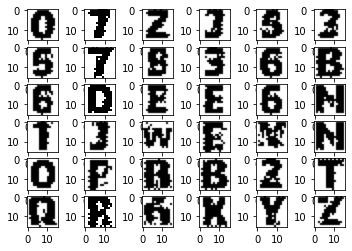

In [16]:
# Step 5
def gaussian_noise(img, mean, sigma, percentage):
    # Generate gauss noise
#     print(img)
    gaussian_out=img
    noise = np.random.normal(mean, sigma, int(percentage*256))
    # Add the noise to image
    gp = np.random.uniform(0,255,int(percentage*256))
    for i in range(int(percentage*256)):
        if gaussian_out[int(gp[i])]==1:
            gaussian_out[int(gp[i])]-=abs(noise[i])
        else:
            gaussian_out[int(gp[i])]+=abs(noise[i])
    #gaussian_out = img + noise
    # Make the value between 0 and 1
    return gaussian_out

gaussian_dataset = np.zeros([5, 9, 36, 256])
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
perc = [0.1, 0.2, 0.25, 0.3, 0.35]

if not os.path.exists('./input_noise2/'):
        os.mkdir('./input_noise2/')
for k in range(5):
    if not os.path.exists('./input_noise2/'+ str(perc[k]) + '/' ):
        os.mkdir('./input_noise2/' + str(perc[k]) + '/' )

for k in range(5):
    for j in range(9):
        if not os.path.exists('./input_noise2/' + str(perc[k]) + '/' + str(std[j])):
            os.mkdir('./input_noise2/' + str(perc[k]) + '/' + str(std[j]))
        for i in range(36):
            inputImage = dataSet2[i].copy()
            gaussian_data = gaussian_noise(inputImage, 0, std[j], perc[k])
            img = gaussian_data.reshape(16, 16)*255
            img = Image.fromarray(np.uint8(img))
            img.convert("1")
            
            inputImageDir = './input_noise2/' + str(perc[k]) + '/' + str(std[j]) + '/' + str(i) + '.png'
            img.save(inputImageDir)
            gaussian_dataset[k][j][i] = gaussian_data
gaussian_dataset = np.array(gaussian_dataset)

Fh_noise_array1 = np.zeros([5, 9, 36])
Ffa_noise_array1 = np.zeros([5, 9, 36])
Fh_noise_array2 = np.zeros([5, 9, 36])
Ffa_noise_array2 = np.zeros([5, 9, 36])

# Train 9 datasets with noise
if not os.path.exists('./output_noise2/'):
        os.mkdir('./output_noise2/')
for k in range(5):
    if not os.path.exists('./output_noise2/' + str(perc[k]) + '/'):
        os.mkdir('./output_noise2/' + str(perc[k]) + '/')
for k in range(5):
    for j in range(9):
        train_noise_dataset = DigitDataset(dataset = gaussian_dataset[k][j], label_list = dataSet)
        train_noise_loader = DataLoader(dataset=train_noise_dataset, batch_size=batch_size, shuffle=False)
        print('Training dataset with noise standard deviation ' + str(std[j]))
    #     model_noise = torch.load('./models/net_untrained.pkl') #  Load the model that trained before
        model_noise = Perceptron(input_size=input_size, d_hidden = d_hidden, num_classes=num_classes).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model_noise.parameters(), lr=learning_rate)

        output_noise, model_noise = train(train_noise_loader, model_noise, num_epochs)   # Train
        torch.save(model_noise, './models1/' + str(k) + '/' + 'net_trained_' + str(std[j]) + '.pkl')
        model_noise = torch.load('./models1/' + str(k) + '/' + 'net_trained_'+ str(std[j]) + '.pkl')
    #     output_noise = model_noise(torch.from_numpy(gaussian_dataset[j]).float()) # Use the model trained before to test
        print('------------------------------------')
        output_noise = model_noise(torch.from_numpy(dataSet).float())
        output_noise_np = output_noise.detach().numpy()     # Get the output
    #     print(output_noise_np)
        output_noise_dataset = np.zeros([36, 256])
    #     Make the output only has 0 or 1
        if not os.path.exists('./output_noise2/' + str(perc[k]) + '/' + str(std[j])):
            os.mkdir('./output_noise2/' + str(perc[k]) + '/' + str(std[j]))
    
    
        for i in range(36):
            output_noise_img = output_noise_np[i].reshape(16, 16)*255
            img = Image.fromarray(np.uint8(output_noise_img))
            img = img.convert("1")
            plt.subplot(6,6,i+1)
            plt.imshow(img)
            output_path = './output_noise2/' + str(perc[k]) + '/' + str(std[j]) + '/' + str(i) + '.png'
            img.save(output_path)
            data = img.getdata()
            array = np.array(data)/255
            output_noise_dataset[i] = array
#     Calculate Fh and Ffa
        Fh1 = calculateFh(dataSet, output_noise_dataset)
        Ffa1 = calculateFfa(dataSet, output_noise_dataset)
        Fh2 = calculateFh(dataSet2, output_noise_dataset)
        Ffa2 = calculateFfa(dataSet2, output_noise_dataset)
        Fh_noise_array1[k][j] = Fh1
        Ffa_noise_array1[k][j] = Ffa1
        Fh_noise_array2[k][j] = Fh2
        Ffa_noise_array2[k][j] = Ffa2
print('------------Fh_noise_array------------')
print(Fh_noise_array)
print('------------Ffa_noise_array------------')
print(Ffa_noise_array)

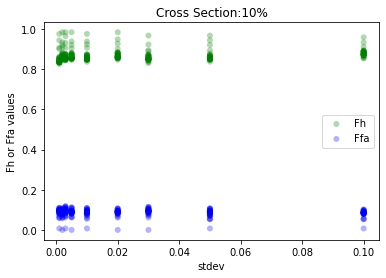

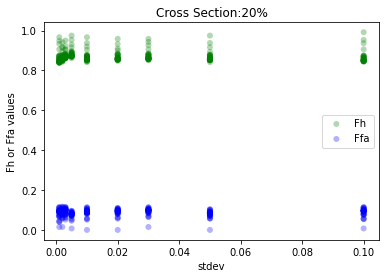

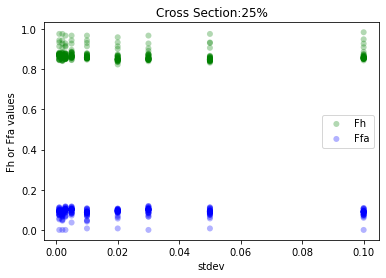

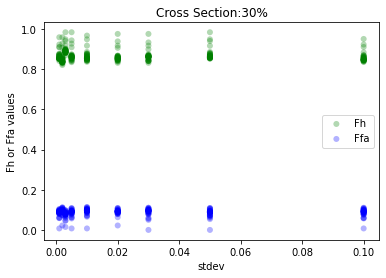

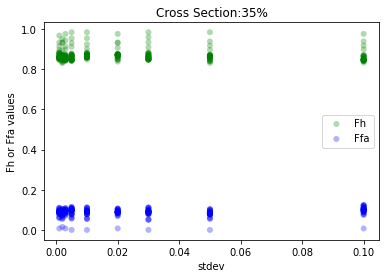

In [17]:
# [1] Display the Fh
# display the scatter plot of fh ffa with noise. 
# Use output Y' with X' as the reference dataset
noise_cross_section= [10,20,25,30,35]
for cross_section in range(len(noise_cross_section)):
    std_plot = [[i for _ in range(36)] for i in std]
    fig, ax = plt.subplots()
    plt.title("Cross Section:"+str(noise_cross_section[cross_section])+"%")
    ax.scatter(std_plot, Fh_noise_array1[cross_section], c="green", label="Fh", alpha=0.3, edgecolors='none')
#     print(Fh_noise_array1[cross_section])
    ax.scatter(std_plot, Ffa_noise_array1[cross_section], c="blue", label="Ffa", alpha=0.3, edgecolors='none')
    plt.xlabel("stdev")
    plt.ylabel("Fh or Ffa values")
    #plt.xscale("log")
    #plt.yscale("symlog")
    ax.legend()
    plt.show()

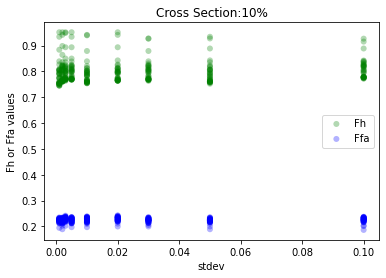

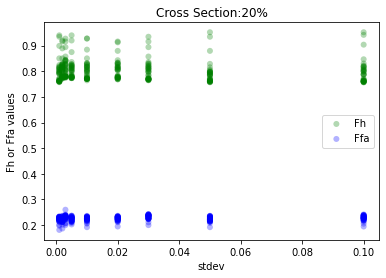

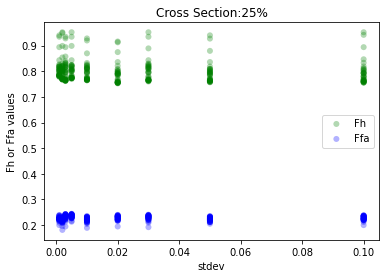

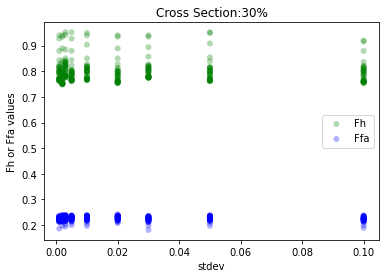

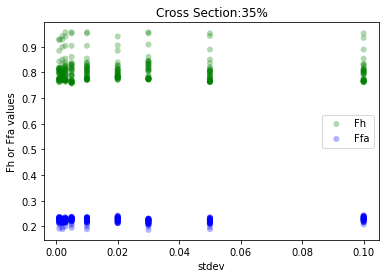

In [18]:
# [2] Display the Fh
# display the scatter plot of fh ffa with noise. 
# Use output Y' with X (instead of X') as the reference dataset
noise_cross_section= [10,20,25,30,35]
for cross_section in range(len(noise_cross_section)):
    std_plot = [[i for _ in range(36)] for i in std]
    fig, ax = plt.subplots()
    plt.title("Cross Section:"+str(noise_cross_section[cross_section])+"%")
    ax.scatter(std_plot, Fh_noise_array2[cross_section], c="green", label="Fh", alpha=0.3, edgecolors='none')
    ax.scatter(std_plot, Ffa_noise_array2[cross_section], c="blue", label="Ffa", alpha=0.3, edgecolors='none')
    plt.xlabel("stdev")
    plt.ylabel("Fh or Ffa values")
    #plt.xscale("log")
    #plt.yscale("symlog")
    ax.legend()
    plt.show()

In [ ]:
# Remoaining 
# 1. noise visualization
#    - graphs
#    - table
# 2. 4c Questions (report)
# TODO: Step 4c: Answer 2 questions from canvas
# Q1-a Yes there is mismatch
# Q1-b Should we compare Dataset2 output vs Dataset1 input?
# Why or why not?  (Justify your answer with analysis in the report generated in Step 8, below, and think about test, training, and validation datasets).
# We use Dataset1 to train out model. Dataset2 output (Y') should be seen as unseem dataset. We should refer 
# TODO visualize Y' (dataset2 output) with X (dataset1 input) to Justify answer (think about test, training)
# Q2 32x32

# Extra credit 
# 1. adjust hyperparameter
# 2. visualization

# Report
# 
